# Simulation of random time series that mimic natural behaviors
* with trend, seasonality, bursts and noise

# Imports

In [1]:
import os
import sys
from datetime import datetime

import pandas as pd
import numpy as np

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")

# Simulation functions for random time series

In [2]:
def generate_random_ones_zeros_series(series_length, ratio_of_ones):
    '''
    Generate a ranodom array of zeros of ones, with a chosen ratio of ones
    series_length: length of series
    ratio_of_ones: ratio of ones in series
    '''
    ones_num = int(ratio_of_ones * series_length)
    new_series = np.zeros(series_length)
    new_series[:ones_num] = 1
    new_series = np.random.permutation(new_series)
    new_series = np.random.permutation(new_series)
    return(new_series)

def shift_series(series):
    '''
    Randomly shifting the basic series that creates seasonal part
    series: array or list
    '''
    series_length = len(series)
    break_point = np.random.randint(int(0.7*series_length))
    temp = []
    temp.extend(series[break_point:series_length])
    temp.extend(series[0:break_point])
    return(temp)

def generate_seasonal_series(final_length, peak_number, mean_roll_window=6):
    '''
    Generting seasonal series from a basic building block
    final_length: final length of the series
    peak_number: how many seasonal peaks to generate
    mean_roll_window: smoothing the siganl using the rooling window
    '''
    basic_series = [1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
    basic_series = shift_series(basic_series)
    basic_series = (
        pd.Series(basic_series) * 10
    )
    concat_list = []
    for i in range(peak_number):
        concat_list.append(basic_series)
    concat_series = pd.concat(concat_list).reset_index(drop=True)
    concat_series = concat_series * (pd.Series(np.random.random(size=concat_series.shape[0])) * 0.2  + 0.8)
    concat_series = concat_series.astype(int)

    step_factor = int(final_length / concat_series.shape[0])

    temp_array = np.zeros(final_length)
    temp_array[:] = np.nan
    temp_array[
        np.arange(0, step_factor * concat_series.shape[0], step_factor)
    ] = concat_series
    final = pd.Series(temp_array).interpolate().rolling(mean_roll_window).mean().fillna(method='bfill')
    noise = pd.Series(np.random.randint(-5, 5, size=final_length))
    final = final + noise + np.random.randint(-25, 25)
    final[final < 0] = 0
    return final


def generate_trend_series(series_length):
    '''
    Generting trend series
    series_length: length of series to generate
    '''
    series = pd.Series(np.random.normal(0, 2, size=series_length)).astype(float)
    series_cumsum = series.cumsum()
    series_cumsum_positive = series_cumsum + int(1.3 * abs(series_cumsum.min()))
    noise_factor = int(0.3 * series.max())
    noise = pd.Series(np.random.randint(-1*noise_factor, noise_factor, size=series_length))
    noise = noise * generate_random_ones_zeros_series(series_length, 0.2)
    noise = noise.rolling(6).mean().fillna(method='bfill')
    series_cumsum_positive_noise = series_cumsum_positive + noise
    series_cumsum_positive_noise[series_cumsum_positive_noise < 0] = 0
    return series_cumsum_positive_noise


def scale_series(series):
    '''
    returns a dataframe of the series
    '''
    x = pd.DataFrame(series).values  # returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x) * 95 + 3
    scaled_series = pd.DataFrame(x_scaled)  # .transpose()+1
    return scaled_series

In [3]:
def add_burst_noise(series):
    '''
    Adding burss of noise to a series
    series: series to add noise to
    '''
    series_length = series.shape[0]
    noise_boundry_percentage = 0.5
    max_signal_noise = series.max() * noise_boundry_percentage
    min_signal_noise = series.min() * noise_boundry_percentage   
    
    bursts_percentage = 0.001
    bursts = generate_random_ones_zeros_series(series_length, bursts_percentage)
    
    mean_rolling_window = 6
    noise = pd.Series(np.random.randint(-1*max_signal_noise, max_signal_noise, size=series_length)) * pd.Series(bursts)
    new_series = series + noise.rolling(mean_rolling_window).mean().fillna(method='bfill')
    return(new_series)

def generate_scaled_seasonal_trend_ts(
    series_length, date_idx, peak_number, mean_roll_window, seasonal_series_weight
):
    '''
    Generate a scaled time series that has prperties of trend, sesonality with date index
    series_length: length of series to generate
    date_idx: date index to add to the time series
    peak_number: how many seasonal peaks to generate
    mean_roll_window: smoothing the siganl using the rooling window
    seasonal_series_weight:the relative weight the seasonal signal is getting comapred to the trend signal
    '''
    simulated_seasonal_series = generate_seasonal_series(
        series_length, peak_number, mean_roll_window
    )
    simulated_trend_series = generate_trend_series(series_length)
    joined_simulated_series = (
        simulated_seasonal_series * seasonal_series_weight + simulated_trend_series
    ).rolling(6).mean().fillna(method='bfill')
    joined_simulated_series = add_burst_noise(joined_simulated_series)
    mean_roll_window = int(0.000005*series_length) # final smoothing window
    joined_simulated_series = scale_series(joined_simulated_series).rolling(mean_roll_window).mean().fillna(method='bfill')
    final_simulated_series_with_date = joined_simulated_series.set_index(date_idx)
    return final_simulated_series_with_date

## Eample of one series

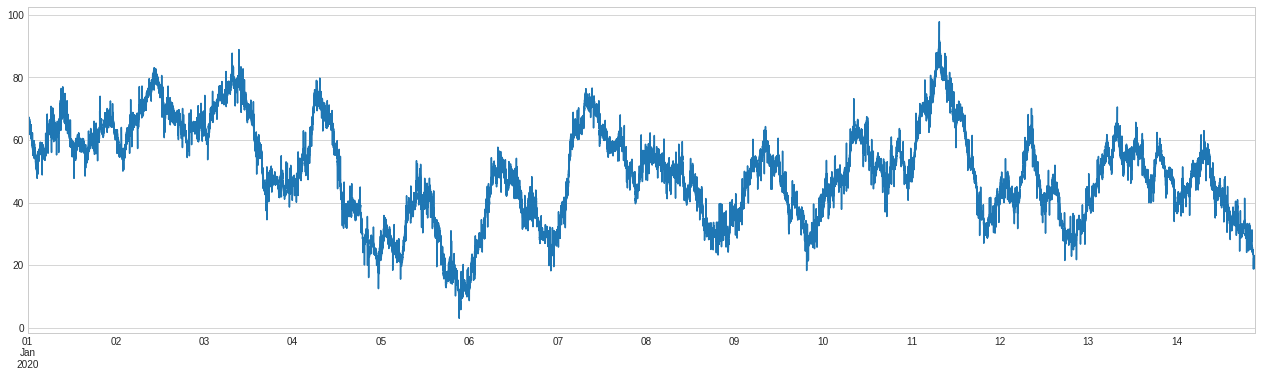

In [4]:
series_length = 1200000
date_idx = pd.date_range(start="1/1/2020", periods=series_length, freq="s")
peak_number = 14  # How many peaks in the seasonal series
mean_roll_window = int(0.001*series_length)  # Smothing window
seasonal_series_weight = 10
final_simulated_series_with_date = generate_scaled_seasonal_trend_ts(
    series_length, date_idx, peak_number, mean_roll_window, seasonal_series_weight
)
final_simulated_series_with_date[0].plot(figsize=(22,6))

# Generating several time series in one dataframe

In [5]:
num_series_to_generate = 10
series_length = 1200000 # 1200000
starting_date = "1/1/2020"
series_freq = "s"
date_idx = pd.date_range(start=starting_date, periods=series_length, freq=series_freq)
flag_first = True
df_simulated_series_with_date = None
for i in range(num_series_to_generate):
    peak_number = 14  # How many peaks in the seasonal series
    mean_roll_window = int(0.001*series_length)  # Smothing window
    seasonal_series_weight = 10
    
    if flag_first:
        flag_first = False
        df_simulated_series_with_date = generate_scaled_seasonal_trend_ts(
            series_length, date_idx, peak_number, mean_roll_window, seasonal_series_weight
        )
    else:
        df_temp = generate_scaled_seasonal_trend_ts(
            series_length, date_idx, peak_number, mean_roll_window, seasonal_series_weight
        )
        df_simulated_series_with_date[i] = df_temp[0]


In [6]:
df_simulated_series_with_date.head(10)

,0,1,2,3,4,5,6,7,8,9
2020-01-01 00:00:00,17.801339,30.924563,62.526581,83.119275,80.011415,61.914122,23.021496,21.906879,76.106351,16.050579
2020-01-01 00:00:01,17.801339,30.924563,62.526581,83.119275,80.011415,61.914122,23.021496,21.906879,76.106351,16.050579
2020-01-01 00:00:02,17.801339,30.924563,62.526581,83.119275,80.011415,61.914122,23.021496,21.906879,76.106351,16.050579
2020-01-01 00:00:03,17.801339,30.924563,62.526581,83.119275,80.011415,61.914122,23.021496,21.906879,76.106351,16.050579
2020-01-01 00:00:04,17.801339,30.924563,62.526581,83.119275,80.011415,61.914122,23.021496,21.906879,76.106351,16.050579
2020-01-01 00:00:05,17.801339,30.924563,62.526581,83.119275,80.011415,61.914122,23.021496,21.906879,76.106351,16.050579
2020-01-01 00:00:06,17.875489,30.924853,62.490781,83.148809,80.012256,61.923016,23.068176,21.902983,76.120389,16.068229
2020-01-01 00:00:07,17.950850,30.926784,62.480518,83.187353,80.016932,61.894810,23.162219,21.894891,76.111612,16.125570
2020-01-01 00:00:08,18.008460,30.940283,62.508663,83.248248,80.023641,61.848368,23.200979,21.896969,76.131475,16.156655
2020-01-01 00:00:09,18.061506,30.996827,62.535003,83.305953,80.034431,61.827904,23.272850,21.932706,76.162759,16.180017


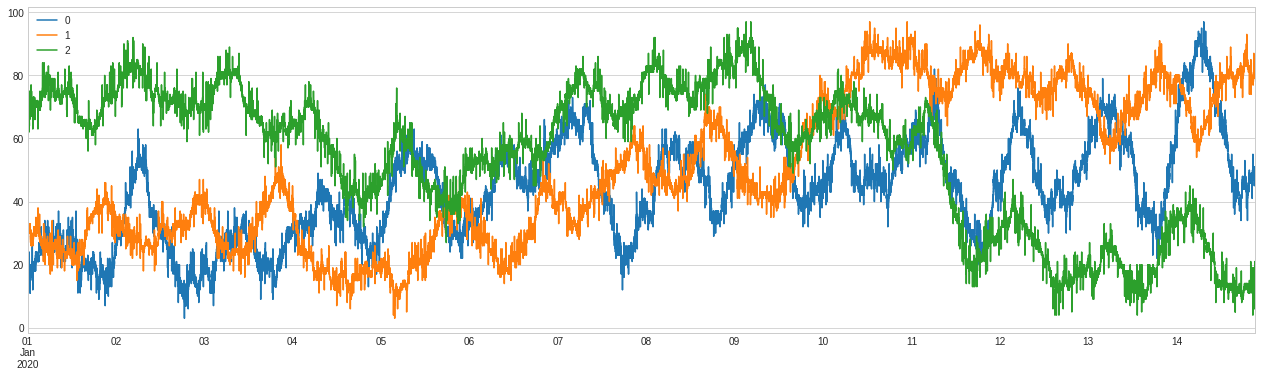

In [7]:
#df_simulated_series_with_date[[0,1]].plot(figsize=(22,6))
df_simulated_series_with_date[[0,1,2]].astype(int).plot(figsize=(22,6))

# Save dataframe to drive

In [62]:
filename = "time_series_data.csv"
df_simulated_series_with_date.astype(int).to_csv(filename, index=False)